# Método Clarke e Wright

1. Obter as distâncias entre todos os nós i e j e destes até o depósito D;
2. Calcular os ganhos de cada par (i , j) e D;
3. Ordenar os pares (i , j), de forma decrescente, segundo os valores dos ganhos gi,j;
4. Para cada par (i , j), tirado da seqüência de combinações, verificar se os dois pontos já fazem parte de um roteiro iniciado;
5. Verificar se o roteiro atende as restrições de tempo e capacidade;
6. Continuar até incluir todos os pontos.

$D_{ij} = \sqrt{(X_{i} - X{j})^2 + (Y_{i} - Y{j})^2}$

$g_{ij} = D_{di} + D_{dj} - D_{ij}$

# Dados iniciais 

|   |X | Y|
|:-:|-:|-:|
|Dep|00.00|00.00|
|1  |13.92|35.98|
|2  |17.20|26.39|
|3  |51.69|12.46|
|4  |99.92|70.68|
|5  |43.78|66.82|
|6  |50.92|40.80|
|7  |09.04|75.68|
|8  |80.22|04.02|
|9  |64.82|55.67|
|10 |38.51|03.19|



In [17]:
from matplotlib import pyplot as plt
import io
import numpy as np
import pandas as pd
import matplotlib.path as mplPath

%matplotlib inline

In [3]:
# initial data

df = pd.read_csv(io.StringIO("""x;y
0;00.00;00.00
1;13.92;35.98
2;17.20;26.39
3;51.69;12.46
4;99.92;70.68
5;43.78;66.82
6;50.92;40.80
7;09.04;75.68
8;80.22;04.02
9;64.82;55.67
10;38.51;03.19"""
), sep=';')

df

,x,y
0,0.00,0.00
1,13.92,35.98
2,17.20,26.39
3,51.69,12.46
4,99.92,70.68
5,43.78,66.82
6,50.92,40.80
7,9.04,75.68
8,80.22,4.02
9,64.82,55.67


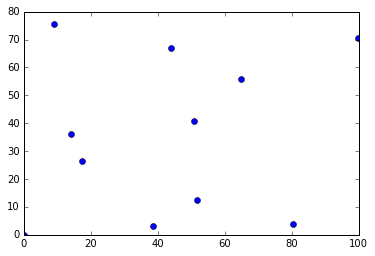

In [4]:
plt.plot(df.x, df.y, 'o')

In [5]:
'''
# distance

$D_{ij} = \sqrt{(X_{i} - X{j})^2 + (Y_{i} - Y{j})^2}$

'''
df_distance = pd.DataFrame({
    i: [np.sqrt((df.x[i] - df.x[j])**2 + (df.y[i] - df.y[j])**2) 
        for j in df.index
       ] for i in df.index
}, index=df.index, columns=df.index)

df_distance

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,38.578839,31.500351,53.170553,122.391457,79.884922,65.249417,76.218003,80.320662,85.444610,38.641897
1,38.578839,0.000000,10.135408,44.494531,92.736670,42.926975,37.312631,39.998805,73.601166,54.575691,40.986000
2,31.500351,10.135408,0.000000,37.196841,93.830712,48.384722,36.669967,49.960882,66.872545,55.901546,31.501684
3,53.170553,44.494531,37.196841,0.000000,75.602257,54.932483,28.350459,76.261333,29.752218,45.160835,16.113513
4,122.391457,92.736670,93.830712,75.602257,0.000000,56.272544,57.391762,91.017440,69.510040,38.174731,91.247401
5,79.884922,42.926975,48.384722,54.932483,56.272544,0.000000,26.981846,35.852018,72.606567,23.811848,63.847864
6,65.249417,37.312631,36.669967,28.350459,57.391762,26.981846,0.000000,54.502741,47.024019,20.355021,39.604548
7,76.218003,39.998805,49.960882,76.261333,91.017440,35.852018,54.502741,0.000000,101.003703,59.260514,78.251396
8,80.320662,73.601166,66.872545,29.752218,69.510040,72.606567,47.024019,101.003703,0.000000,53.896962,41.718257
9,85.444610,54.575691,55.901546,45.160835,38.174731,23.811848,20.355021,59.260514,53.896962,0.000000,58.705762


step #1


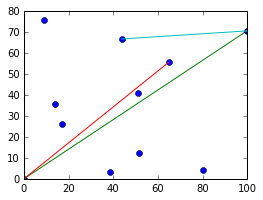

step #2


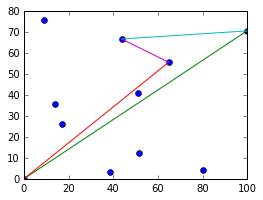

step #3


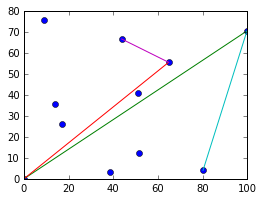

step #4


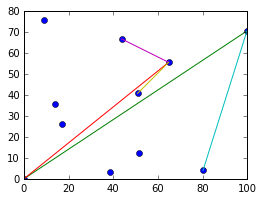

step #5


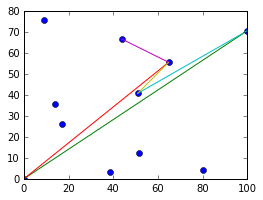

step #6


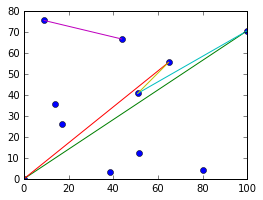

step #7


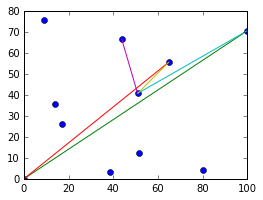

step #8


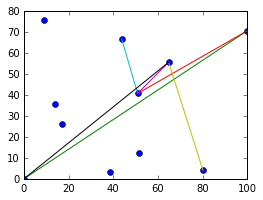

step #9


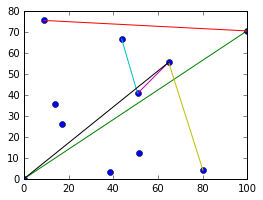

step #10


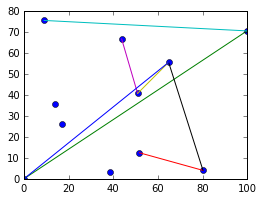

step #11


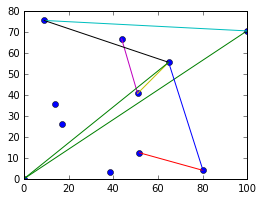

step #12


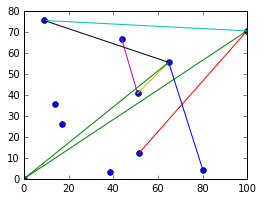

step #13


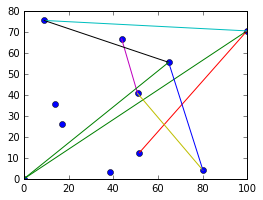

step #14


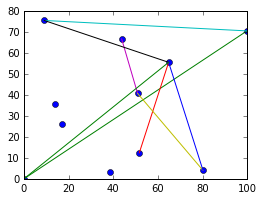

step #15


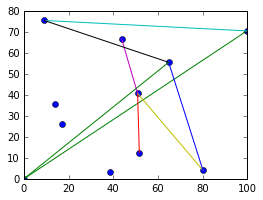

step #16


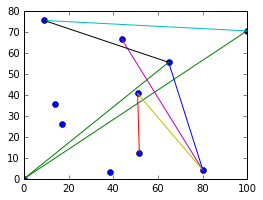

step #17


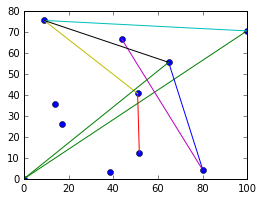

step #18


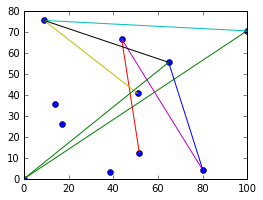

step #19


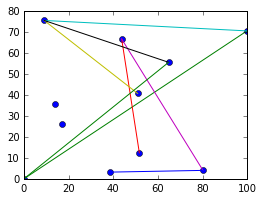

step #20


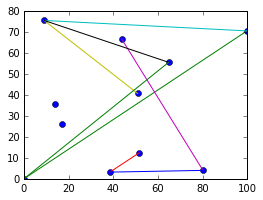

step #21


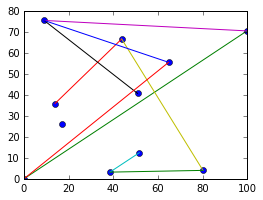

step #22


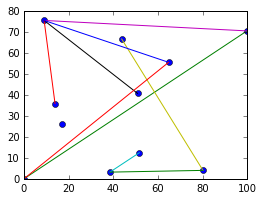

step #23


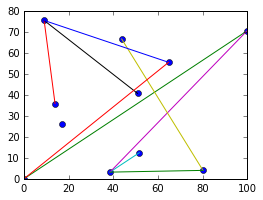

step #24


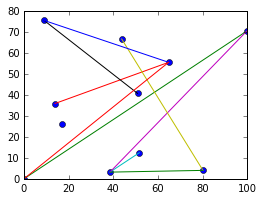

step #25


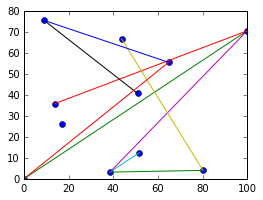

step #26


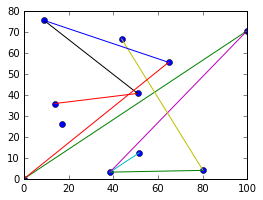

step #27


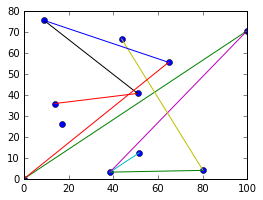

step #28


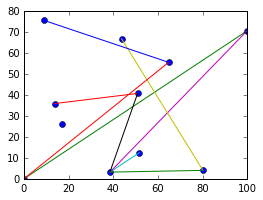

step #29


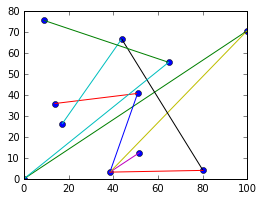

step #30


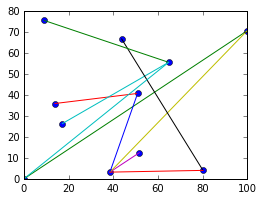

step #31


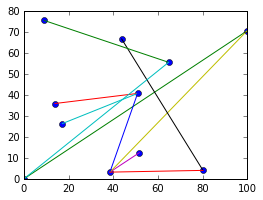

step #32


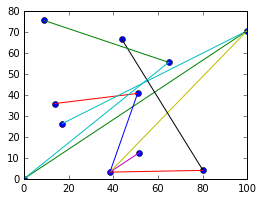

step #33


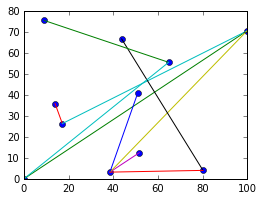

step #34


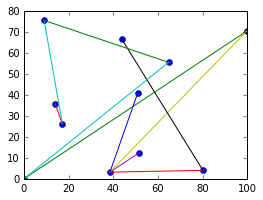

step #35


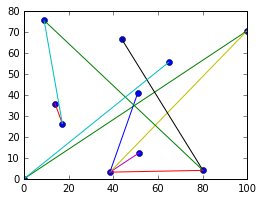

step #36


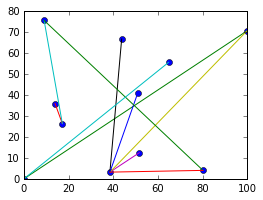

step #37


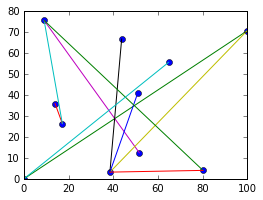

step #38


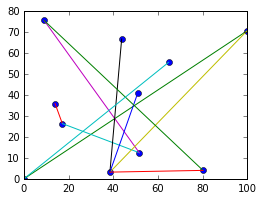

step #39


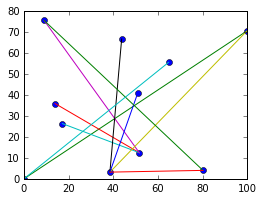

step #40


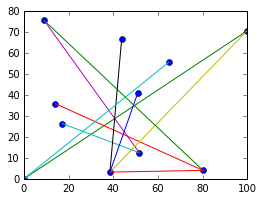

step #41


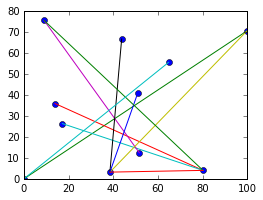

step #42


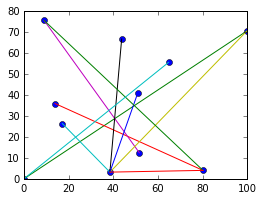

step #43


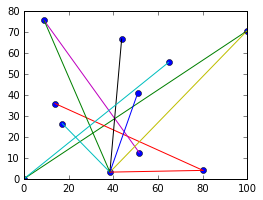

step #44


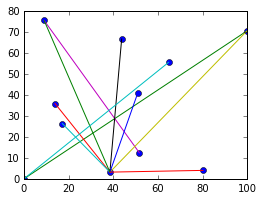

In [16]:
'''
# gain

$g_{ij} = D_{di} + D_{dj} - D_{ij}$

'''
n = df.shape[0]
df_gain = pd.DataFrame({
    '%s_%s' % ((i, j) if i < j else (j, i)):
        [df_distance.iloc[0, i] + 
         df_distance.iloc[0, j] - 
         df_distance.iloc[i, j]]
        for i in df.index[1:] for j in range(i,n)
        if not i == j
}).T.sort_values(by=[0], ascending=[False])

assert df_gain.shape[0] == (df.shape[0]-1)*(df.shape[0]-2)/2

routes = [{'frontier': {}, 'border': []}]

# first iteration
_id = df_gain.iloc[0].name.split('_')
k1, k2 = map(int, _id)
df_gain.drop(df_gain.index[0], inplace=True)

routes[0]['border'] = [k1, k2]

step = 1
while not df_gain.empty:
    print("step #%s" % step)
    step += 1

    _id = df_gain.iloc[0].name.split('_')
    k1, k2 = map(int, _id)
    df_gain.drop(df_gain.index[0], inplace=True)
    
    if(
        bbPath.contains_point((df[k1].x, df[k1].y)) or
        bbPath.contains_point((df[k2].x, df[k2].y))
    )
    
    routes[0]['frontier'][k1] = k2
    routes[0]['frontier'][0] = routes[0]['border'][0]
    routes[0]['frontier'][routes[0]['border'][1]] = 0
    
    plt.figure(figsize=(4,3))
    plt.plot(df.x, df.y, 'o')
    '''
    plt.plot([0, df.iloc[border[0]].x], [0, df.iloc[border[0]].y])
    plt.plot([0, df.iloc[border[1]].x], [0, df.iloc[border[1]].y])
    '''
    
    for k1, k2 in routes[0]['frontier'].items():
        plt.plot(
            [df.iloc[k1].x, df.iloc[k2].x], 
            [df.iloc[k1].y, df.iloc[k2].y]
        )
    plt.show()